<a href="https://colab.research.google.com/github/anupojuharshita/PathPlanning/blob/main/static%20o-p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, sys
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device


Torch: 2.8.0+cu126 | CUDA available: False


'cpu'

In [ ]:
from google.colab import files
up = files.upload()  # pick st_rdp_dataset_200.npz



Saving st_rdp_dataset_200.npz to st_rdp_dataset_200.npz


In [ ]:
ds_path = "/content/st_rdp_dataset_200.npz"

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

data = np.load(ds_path)
R_np, S_np, G_np, T_np = data["R"], data["S"], data["G"], data["T"]
N, K, H, W = R_np.shape
print("Shapes:", R_np.shape, S_np.shape, G_np.shape, T_np.shape)

class TrajDataset(Dataset):
    def __init__(self, R, S, G, T):
        self.R = R.astype(np.float32)
        self.S = S.astype(np.float32)
        self.G = G.astype(np.float32)
        self.T = T.astype(np.float32)
    def __len__(self): return self.R.shape[0]
    def __getitem__(self, i):
        import torch
        return (
            torch.from_numpy(self.R[i]),  # (K,H,W)
            torch.from_numpy(self.S[i]),  # (4,)
            torch.from_numpy(self.G[i]),  # (2,)
            torch.from_numpy(self.T[i])   # (K,2)
        )

idx = np.arange(N); np.random.seed(0); np.random.shuffle(idx)
split = int(0.85*N)
tr_idx, va_idx = idx[:split], idx[split:]
train_ds = TrajDataset(R_np[tr_idx], S_np[tr_idx], G_np[tr_idx], T_np[tr_idx])
val_ds   = TrajDataset(R_np[va_idx], S_np[va_idx], G_np[va_idx], T_np[va_idx])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, drop_last=False)


Shapes: (200, 20, 64, 64) (200, 4) (200, 2) (200, 20, 2)


In [ ]:
import math
import torch.nn as nn
import torch.nn.functional as F

class ContextEncoder(nn.Module):
    def __init__(self, K, H, W, ctx_dim=128):
        super().__init__()
        in_ch = K  # treat time as channels
        self.cnn = nn.Sequential(
            nn.Conv2d(in_ch, 16, 5, padding=2), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc_state = nn.Sequential(
            nn.Linear(6, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU()
        )
        self.fuse = nn.Sequential(nn.Linear(64+64, ctx_dim), nn.ReLU())
    def forward(self, R, s, g):
        x = self.cnn(R)[:, :, 0, 0]       # (B,64)
        sg = torch.cat([s, g], dim=-1)    # (B,6)
        sg = self.fc_state(sg)            # (B,64)
        return self.fuse(torch.cat([x, sg], dim=-1))  # (B,ctx_dim)

class TimeEmbedding(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Linear(dim, dim))
        self.dim = dim
    def forward(self, t):  # t in [0,1], shape (B,)
        half = self.dim // 2
        freqs = torch.arange(half, device=t.device).float()
        ang = (2*math.pi) * t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(ang), torch.cos(ang)], dim=-1)
        return self.fc(emb)

class TrajUNet1D(nn.Module):
    def __init__(self, K, ctx_dim=128, hidden=64):
        super().__init__()
        self.tproj = nn.Linear(64, hidden)
        self.cproj = nn.Linear(ctx_dim, hidden)
        self.e1 = nn.Conv1d(2, hidden, 3, padding=1)
        self.e2 = nn.Conv1d(hidden, hidden, 3, padding=1)
        self.d1 = nn.Conv1d(hidden, hidden, 3, padding=1)
        self.out = nn.Conv1d(hidden, 2, 3, padding=1)
        self.bn = nn.BatchNorm1d(hidden)
        self.act = nn.SiLU()
    def forward(self, tau_noisy, t_emb, ctx):
        x = tau_noisy.permute(0,2,1)     # (B,2,K)
        h = self.act(self.e1(x))
        h = self.bn(self.act(self.e2(h)))
        t = self.tproj(t_emb).unsqueeze(-1)  # (B,H,1)
        c = self.cproj(ctx).unsqueeze(-1)    # (B,H,1)
        h = h + t + c
        h = self.act(self.d1(h))
        out = self.out(h)                # (B,2,K)
        return out.permute(0,2,1)        # (B,K,2)

class ST_RDP(nn.Module):
    def __init__(self, K, H, W, ctx_dim=128):
        super().__init__()
        self.ctx = ContextEncoder(K,H,W,ctx_dim)
        self.temb = TimeEmbedding(64)
        self.denoiser = TrajUNet1D(K, ctx_dim, hidden=64)
    def forward(self, R, s, g, tau_noisy, t_scalar):
        t_emb = self.temb(t_scalar)
        ctx = self.ctx(R, s, g)
        return self.denoiser(tau_noisy, t_emb, ctx)

model = ST_RDP(K=K, H=H, W=W).to(device)
sum(p.numel() for p in model.parameters())/1e6


0.098674

In [ ]:
def beta_schedule(T=200, start=1e-4, end=0.02, device="cpu"):
    return torch.linspace(start, end, T, device=device)

def index_like(a, t, x):
    return a.gather(0, t).reshape(x.shape[0], *((1,)*(x.ndim-1)))

def soft_collision_penalty(traj, R, res=1.0, origin=(0.0,0.0)):
    # traj: (B,K,2), R: (B,K,H,W) in [0,1]
    B,K,_ = traj.shape
    H,W = R.shape[2], R.shape[3]
    ix = ((traj[...,0]-origin[0]) / res).clamp(0, W-1-1e-6)
    iy = ((traj[...,1]-origin[1]) / res).clamp(0, H-1-1e-6)
    ix0 = ix.long(); iy0 = iy.long()
    risk = R[torch.arange(B)[:,None], torch.arange(K)[None,:], iy0, ix0]  # (B,K)
    return risk.mean()

def smoothness_penalty(traj):
    diffs = traj[:,1:,:]-traj[:,:-1,:]
    return (diffs**2).sum(dim=-1).mean()

def goal_penalty(traj, g):
    end = traj[:,-1,:]
    return F.mse_loss(end, g)

T_steps = 200
betas  = beta_schedule(T_steps, device=device)
alphas = 1.0 - betas
abar   = torch.cumprod(alphas, dim=0)


In [ ]:
import torch.optim as optim
import torch.nn.functional as F

opt = optim.AdamW(model.parameters(), lr=2e-3)

def train_one_epoch(loader):
    model.train()
    total = 0.0
    for R,s,g,tau0 in loader:
        R = R.to(device)              # (B,K,H,W)
        s = s.to(device)              # (B,4)
        g = g.to(device)              # (B,2)
        tau0 = tau0.to(device)        # (B,K,2)

        B = R.shape[0]
        t = torch.randint(0, T_steps, (B,), device=device)
        eps = torch.randn_like(tau0)
        abar_t = index_like(abar, t, tau0)
        tau_t = torch.sqrt(abar_t)*tau0 + torch.sqrt(1-abar_t)*eps
        t_norm = (t.float() / (T_steps-1)).clamp(0,1)

        eps_hat = model(R, s, g, tau_t, t_norm)
        # predict denoising residual; reconstruct tau0 estimate
        tau_tilde0 = (tau_t - torch.sqrt(1-abar_t)*eps_hat) / torch.sqrt(abar_t + 1e-8)

        loss_eps = F.mse_loss(eps_hat, eps)
        Lc = soft_collision_penalty(tau_tilde0, R)
        Ls = smoothness_penalty(tau_tilde0)
        Lg = goal_penalty(tau_tilde0, g)
        loss = loss_eps + 2.0*Lc + 0.1*Ls + 1.0*Lg

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += float(loss.detach().cpu())
    return total/len(loader)

EPOCHS = 5   # start small; increase later
for e in range(1, EPOCHS+1):
    tr = train_one_epoch(train_loader)
    print(f"epoch {e}/{EPOCHS}  train_loss={tr:.4f}")


epoch 1/5  train_loss=4.7545
epoch 2/5  train_loss=4.8160
epoch 3/5  train_loss=4.4553
epoch 4/5  train_loss=4.3431
epoch 5/5  train_loss=3.8553


In [ ]:
import numpy as np
import torch

@torch.no_grad()
def sample_trajectories(model, R, s, g, K, N_cand=8, S=60, device="cpu"):
    model.eval()
    betas  = beta_schedule(T_steps, device=device)
    alphas = 1.0 - betas
    abar   = torch.cumprod(alphas, dim=0)

    B = N_cand
    Rb = R.expand(B, -1, -1, -1)
    sb = s.expand(B, -1)
    gb = g.expand(B, -1)
    tau = torch.randn((B, K, 2), device=device)

    steps = np.linspace(T_steps-1, 0, S, dtype=int)
    for t in steps:
        t_tensor = torch.full((B,), float(t)/(T_steps-1), device=device)
        eps_hat = model(Rb, sb, gb, tau, t_tensor)
        abar_t = abar[t]
        alpha_t = alphas[t]
        beta_t  = betas[t]
        tau0_tilde = (tau - torch.sqrt(1-abar_t)*eps_hat) / torch.sqrt(abar_t + 1e-8)
        if t > 0:
            noise = torch.randn_like(tau)
            tau = torch.sqrt(alpha_t)*tau + torch.sqrt(1-alpha_t)*eps_hat + torch.sqrt(beta_t)*noise
        else:
            tau = tau0_tilde

    # score candidates (risk + goal) and pick best
    def risk_score(traj, R):
        B,K,_ = traj.shape
        H,W = R.shape[2], R.shape[3]
        ix = torch.clamp(traj[...,0], 0, W-1-1e-6).long()
        iy = torch.clamp(traj[...,1], 0, H-1-1e-6).long()
        risk = R[torch.arange(B)[:,None].to(R.device), torch.arange(K)[None,:].to(R.device), iy, ix].mean(dim=1)
        return risk
    risk = risk_score(tau, Rb)
    goal = torch.linalg.vector_norm(tau[:,-1,:]-gb, dim=-1)
    score = 3.0*risk + goal
    best = int(torch.argmin(score))
    return tau[best].detach()

# pick a validation sample
vidx = 0
R_demo = torch.from_numpy(R_np[va_idx[vidx]][None, ...]).to(device)  # (1,K,H,W)
s_demo = torch.from_numpy(S_np[va_idx[vidx]][None, ...]).to(device)  # (1,4)
g_demo = torch.from_numpy(G_np[va_idx[vidx]][None, ...]).to(device)  # (1,2)

pred_traj = sample_trajectories(model, R_demo, s_demo, g_demo, K, N_cand=8, S=60, device=device)
pred_traj.shape


torch.Size([20, 2])

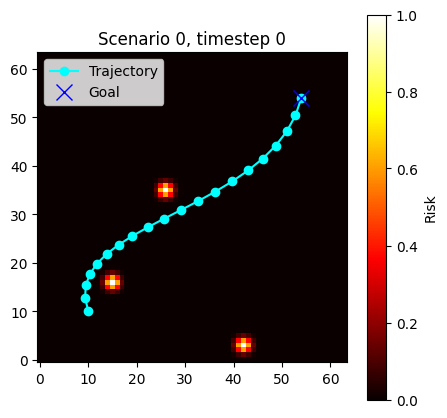

In [ ]:
import matplotlib.pyplot as plt

# pick one scenario
i = 0   # try changing this to see different samples
k = 0   # timestep (0..19)

R_sample = R_np[i, k]      # (64,64) risk map
traj = T_np[i]             # (20,2) safe trajectory
goal = G_np[i]             # (2,)

plt.figure(figsize=(5,5))
plt.imshow(R_sample, cmap="hot", origin="lower", vmin=0, vmax=1)  # scale 0-1
plt.colorbar(label="Risk")

# plot trajectory
plt.plot(traj[:,0], traj[:,1], color="cyan", marker="o", label="Trajectory")

# plot goal
plt.plot(goal[0], goal[1], "bx", markersize=12, label="Goal")

plt.title(f"Scenario {i}, timestep {k}")
plt.legend()
plt.show()


In [ ]:
from matplotlib.animation import PillowWriter
gif_path = "st_rdp_sim.gif"
anim.save(gif_path, writer=PillowWriter(fps=6))
gif_path


'st_rdp_sim.gif'

In [ ]:
!apt -y install ffmpeg
mp4_path = "st_rdp_sim.mp4"
anim.save(mp4_path, writer="ffmpeg", fps=12)
mp4_path


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


'st_rdp_sim.mp4'